In [1]:
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from pyvis.network import Network
import community.community_louvain as community_louvain
from tqdm import tqdm

Importation des données : 

In [65]:
project = pd.read_csv("../Data/CSV/Projects/project.csv", sep=";")

In [66]:
organization = pd.read_csv("../Data/CSV/Projects/organization.csv", sep=";")

Point positif des CSV c'est qu'ils semblent plus propre que les JSON (voir Publications) et les columnes sont dans le bon ordre.

In [4]:
print(project.shape)
print(organization.shape)

(35381, 20)
(177190, 25)


In [5]:
project.columns

Index(['id', 'acronym', 'status', 'title', 'startDate', 'endDate', 'totalCost',
       'ecMaxContribution', 'legalBasis', 'topics', 'ecSignatureDate',
       'frameworkProgramme', 'masterCall', 'subCall', 'fundingScheme',
       'nature', 'objective', 'contentUpdateDate', 'rcn', 'grantDoi'],
      dtype='object')

In [6]:
organization.columns

Index(['projectID', 'projectAcronym', 'organisationID', 'vatNumber', 'name',
       'shortName', 'SME', 'activityType', 'street', 'postCode', 'city',
       'country', 'nutsCode', 'geolocation', 'organizationURL', 'contactForm',
       'contentUpdateDate', 'rcn', 'order', 'role', 'ecContribution',
       'netEcContribution', 'totalCost', 'endOfParticipation', 'active'],
      dtype='object')

On vérifie si on a autant de projectID unique que de ligne dans notre table *project*. Et c'est le cas ! 

In [7]:
len(organization["projectID"].unique())

35381

In [8]:
project.head(1)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,ecSignatureDate,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,2018-05-02,H2020,H2020-EIC-SMEInst-2018-2020,H2020-SMEInst-2018-2020-1,SME-1,NaN,"""Electronic discovery (known as e-discovery) i...",2022-08-10 13:07:21,217713,10.3030/817296


In [9]:
organization.head(1)

,projectID,projectAcronym,organisationID,vatNumber,name,shortName,SME,activityType,street,postCode,...,contactForm,contentUpdateDate,rcn,order,role,ecContribution,netEcContribution,totalCost,endOfParticipation,active
0,817296,eDCaseMAN,907916509,CHE385284385MWST,BRITE GMBH,Brite GmbH,True,PRC,AUF DER SCHANZ 9,4132,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-08-10 13:07:21,1952575,1,coordinator,50000.0,50000.0,71429,False,NaN


In [67]:
project_id = list(project["id"].unique())
print(len(project_id))

35381


On a autant de projectID unique que de lignes dans project ! 

---

Affichons de manière aléatoire toutes les organisation appartenant à un projet (tiré aléatoirement).

In [11]:
organization[organization["projectID"] == random.choice(project_id)]

,projectID,projectAcronym,organisationID,vatNumber,name,shortName,SME,activityType,street,postCode,...,contactForm,contentUpdateDate,rcn,order,role,ecContribution,netEcContribution,totalCost,endOfParticipation,active
88766,954992,CAPSTONE,998323516,CY10164329G,NOVAMECHANICS LIMITED,Novamechanics,True,PRC,DIGENI AKRITA 51,1070,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-04-20 20:40:17,1933242,10,participant,235836.72,235836.72,"235836,72",False,NaN
88767,954992,CAPSTONE,999643007,EL090145420,ETHNIKO KAI KAPODISTRIAKO PANEPISTIMIO ATHINON,NKUA,False,HES,6 CHRISTOU LADA STR,10561,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-04-20 20:40:17,1906280,6,participant,243017.64,243017.64,"243017,64",False,NaN
88768,954992,CAPSTONE,999915189,NL004205315B01,UNIVERSITAIR MEDISCH CENTRUM UTRECHT,UMC UTRECHT,False,HES,HEIDELBERGLAAN 100,3584 CX,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-04-20 20:40:17,1906267,7,participant,265619.88,265619.88,"265619,88",False,NaN
88769,954992,CAPSTONE,969027285,FR82514227255,IMABIOTECH SAS,IMBT,True,PRC,152 RUE DU DOCTEUR YERSIN,59120,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-04-20 20:40:17,2166288,8,participant,274802.04,274802.04,"274802,04",False,NaN
88770,954992,CAPSTONE,999975329,GB568630414,UNIVERSITY OF SOUTHAMPTON,SOUTHAMPTON,False,HES,Highfield,SO17 1BJ,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-04-20 20:40:17,1905627,3,participant,606345.12,606345.12,"606345,12",False,NaN
88771,954992,CAPSTONE,999978239,EL090085651,"""NATIONAL CENTER FOR SCIENTIFIC RESEARCH """"DEM...","""NCSR """"D""""""",False,REC,END OF PATRIARCHOU GRIGORIOU E AND 27 NEAPOLEO...,15341,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-04-20 20:40:17,1905726,2,participant,486035.28,486035.28,"486035,28",False,NaN
88772,954992,CAPSTONE,897691060,FR65130025737,UNIVERSITE PARIS CITE,UP,False,HES,85 BD SAINT GERMAIN,75006,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-04-20 20:40:17,1962992,4,participant,549604.08,549604.08,"549604,08",False,NaN
88773,954992,CAPSTONE,888146648,FR88130029754,UNIVERSITE DE LILLE,UNIVERSITE DE LILLE,False,HES,42 RUE PAUL DUEZ,59000,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-04-20 20:40:17,1973617,1,coordinator,549604.08,549604.08,"549604,08",False,NaN
88774,954992,CAPSTONE,998837810,VATEXEMPTION,OSPEDALE PEDIATRICO BAMBINO GESU,OSPEDALE PEDIATRICO BAMBINO GESU,False,REC,PIAZZA SANT ONOFRIO 4,00165,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-04-20 20:40:17,1909052,5,participant,522999.36,522999.36,"522999,36",False,NaN
88775,954992,CAPSTONE,931365580,CZ03835243,INOCURE SRO,Inocure,True,PRC,POLITICKYCH VEZNU 935/13,11000,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-04-20 20:40:17,2381743,9,participant,234871.56,234871.56,"234871,56",False,NaN


Comptons le nombre d'organisations différentes.

In [12]:
len(organization["organisationID"].unique())

41338

Pour chaque projet je récupère les id des organisations qui y participent. Tout ça dans un dictionnaire.

In [13]:
projet_orga = {}
for projet in project_id:
    projet_orga[projet] = list(organization[organization["projectID"] == projet]["organisationID"])

In [14]:
G = nx.Graph()

In [209]:
yes_counter = 0
for i in range(1, len(projet_orga.keys())):
#     print(projet_orga[project_id[i]])
    G.add_node(project_id[i - 1])
    for y in projet_orga[project_id[i - 1]]:
#         print(f"i: {i} | i+1: {projet_orga[project_id[i+1]]} | y: {y}")
        if G.has_edge(project_id[i - 1], project_id[i]) is False:
            for x in projet_orga[project_id[i]]:
            
                if y == x:
                    yes_counter += 1
                    G.add_edge(project_id[i-1], project_id[i])

100%|███████████████████████████████████████████████████████████████████████▉| 35379/35381 [00:00<00:00, 300709.03it/s]


In [15]:
########### /!\ TOURNE INDEFINIEMENT /!\ ##############

yes_counter = 0
for i, tq in zip(range(1, len(projet_orga.keys())), tqdm(range(len(projet_orga.keys())))):
#     print(projet_orga[project_id[i]])
    for t in range(len(projet_orga.keys())):
#         G.add_node(project_id[i - 1])
        G.add_node(project_id[i - 1], label=project_id[i - 1])
        for y in projet_orga[project_id[i - 1]]:
#         print(f"i: {i} | i+1: {projet_orga[project_id[i+1]]} | y: {y}")
            if G.has_edge(project_id[i - 1], project_id[t]) is False:
                for x in projet_orga[project_id[t]]:
            
                    if y == x:
                        yes_counter += 1
                        G.add_edge(project_id[i-1], project_id[t])

100%|█████████████████████████████████████████████████████████████████████████▉| 35379/35381 [1:02:30<00:00,  9.43it/s]


In [ ]:
# Version optimisé par ChatGPT

import itertools
yes_counter = 0
for i, tq in zip(projet_orga.keys(), tqdm(projet_orga.keys())):
    G.add_node(i, label=i)
    for t in itertools.combinations(projet_orga.keys(), 2):
        if G.has_edge(i, t[1]) is False:
            for y in projet_orga[i]:
                for x in projet_orga[t[1]]:
                    if y == x:
                        yes_counter += 1
                        G.add_edge(i, t[1])
                        break

Trouver un moyen d'enlever les doublons. Par doublons j'entend les combinaisons déjà essayé. Par exemple une fois avoir tester le projet 1 sur tous les autres, ceux où une arrête a été ajouté ne repasse pas. Si y'a une arrête entre 1 et 2 quand on fera tourner 2 on ne regarde pas s'il existe une arrête entre les 2. <br>
<br>
Test un truc style : <br>
`
if G.has_edge(project_id[i], project_id[t]) is False: 
    suite du code...
else: 
    pass
`

On enregristre le graphe :

In [21]:
pickle.dump(G, open('./graphs_save/graphe_3_labeled.pickle', 'wb'))

In [15]:
 G = pickle.load(open("./graphs_save/graphe_3_labeled.pickle", "rb"))

Pour l'ouvrir il suffira d'utiliser cette line de code : 
G = pickle.load(open("filename.pickle", "rb"))

_Je crois que cela n'est pas bon ! Je crois qu'on ne prend les projets que 2 par 2 et pas 1 projet qui regarde les correspondace avec tous les autres etc..._

In [16]:
G.number_of_nodes()

35381

In [17]:
G.number_of_edges()

10017589

Notre graphe ne contient donc que les projets où une des organisation à travailler pour un autre projet ! Donc on n'a pas les organisations qui n'ont pas fait 2 projets. 
Pour régler cela nous avons ajouté *G.add_node()* dans la cellule avec les boucle, en y mettant TOUS les id des projets !

In [18]:
G.remove_edges_from(nx.selfloop_edges(G))

In [19]:
G.number_of_nodes()

35381

In [20]:
G.number_of_edges()

9982209

Affichons maintenant les graphes

In [34]:
nx.draw_networkx(G)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


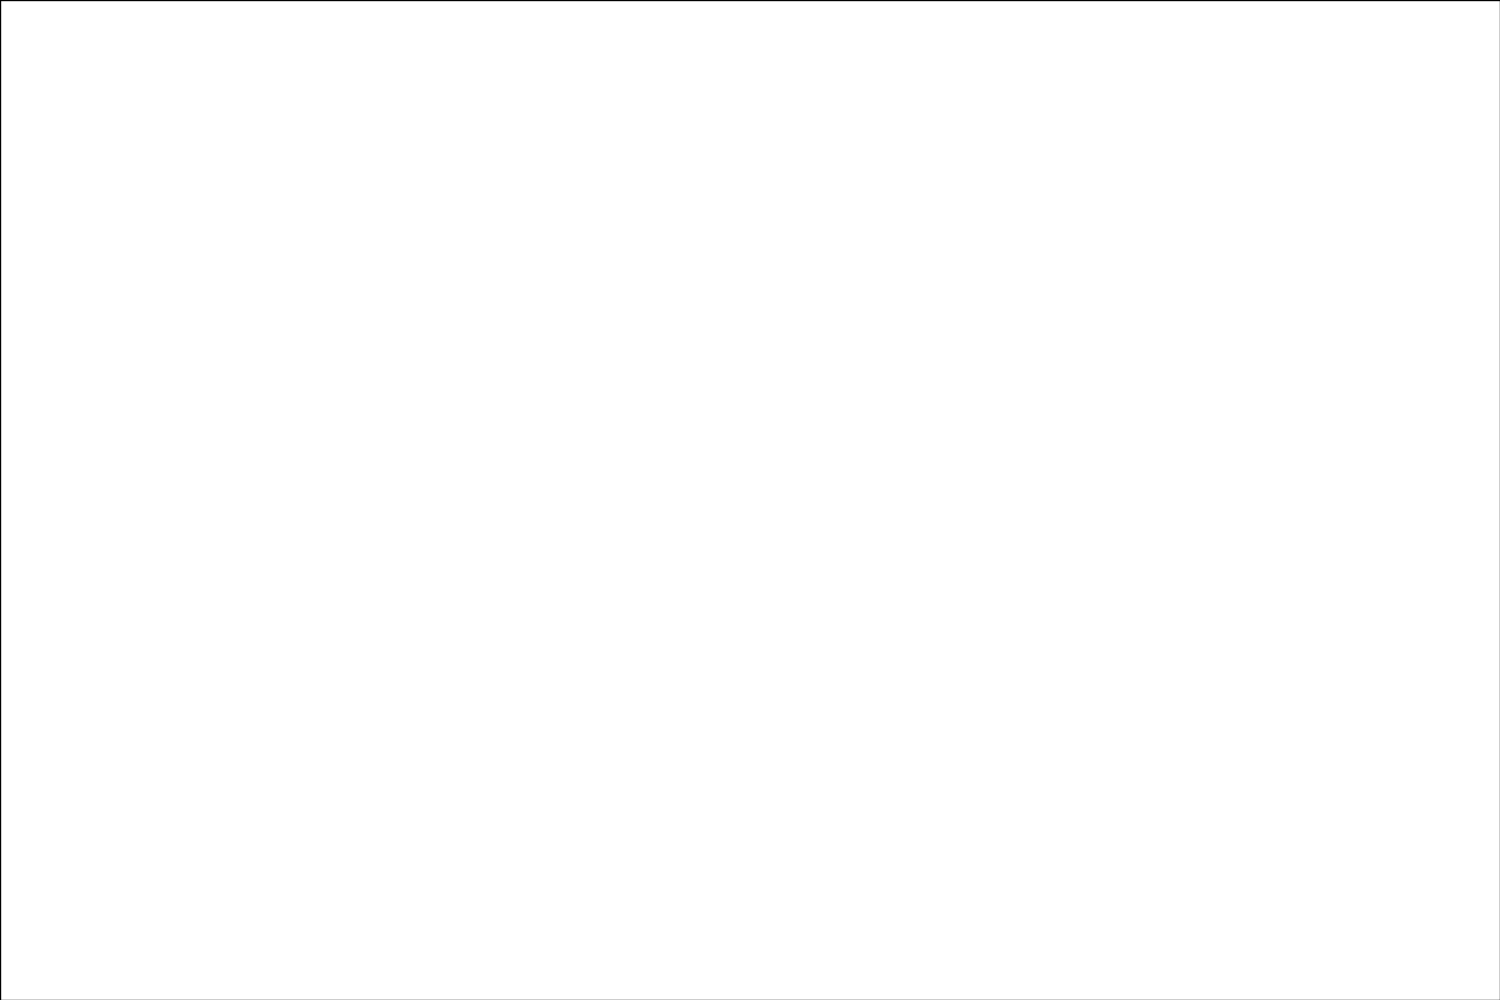

KeyboardInterrupt: 

In [107]:
plt.figure(figsize=(12, 8))

graph_options = {
    'node_color': 'lightblue',
    'node_size' : 10,
    "edge_color": 'black'
}

nx.draw(G, **graph_options)
plt.show()

On va tester une solution venu de stackoverflow:

In [110]:
from matplotlib import pylab
import networkx as nx

def save_graph(graph, file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

<IPython.core.display.Javascript object>


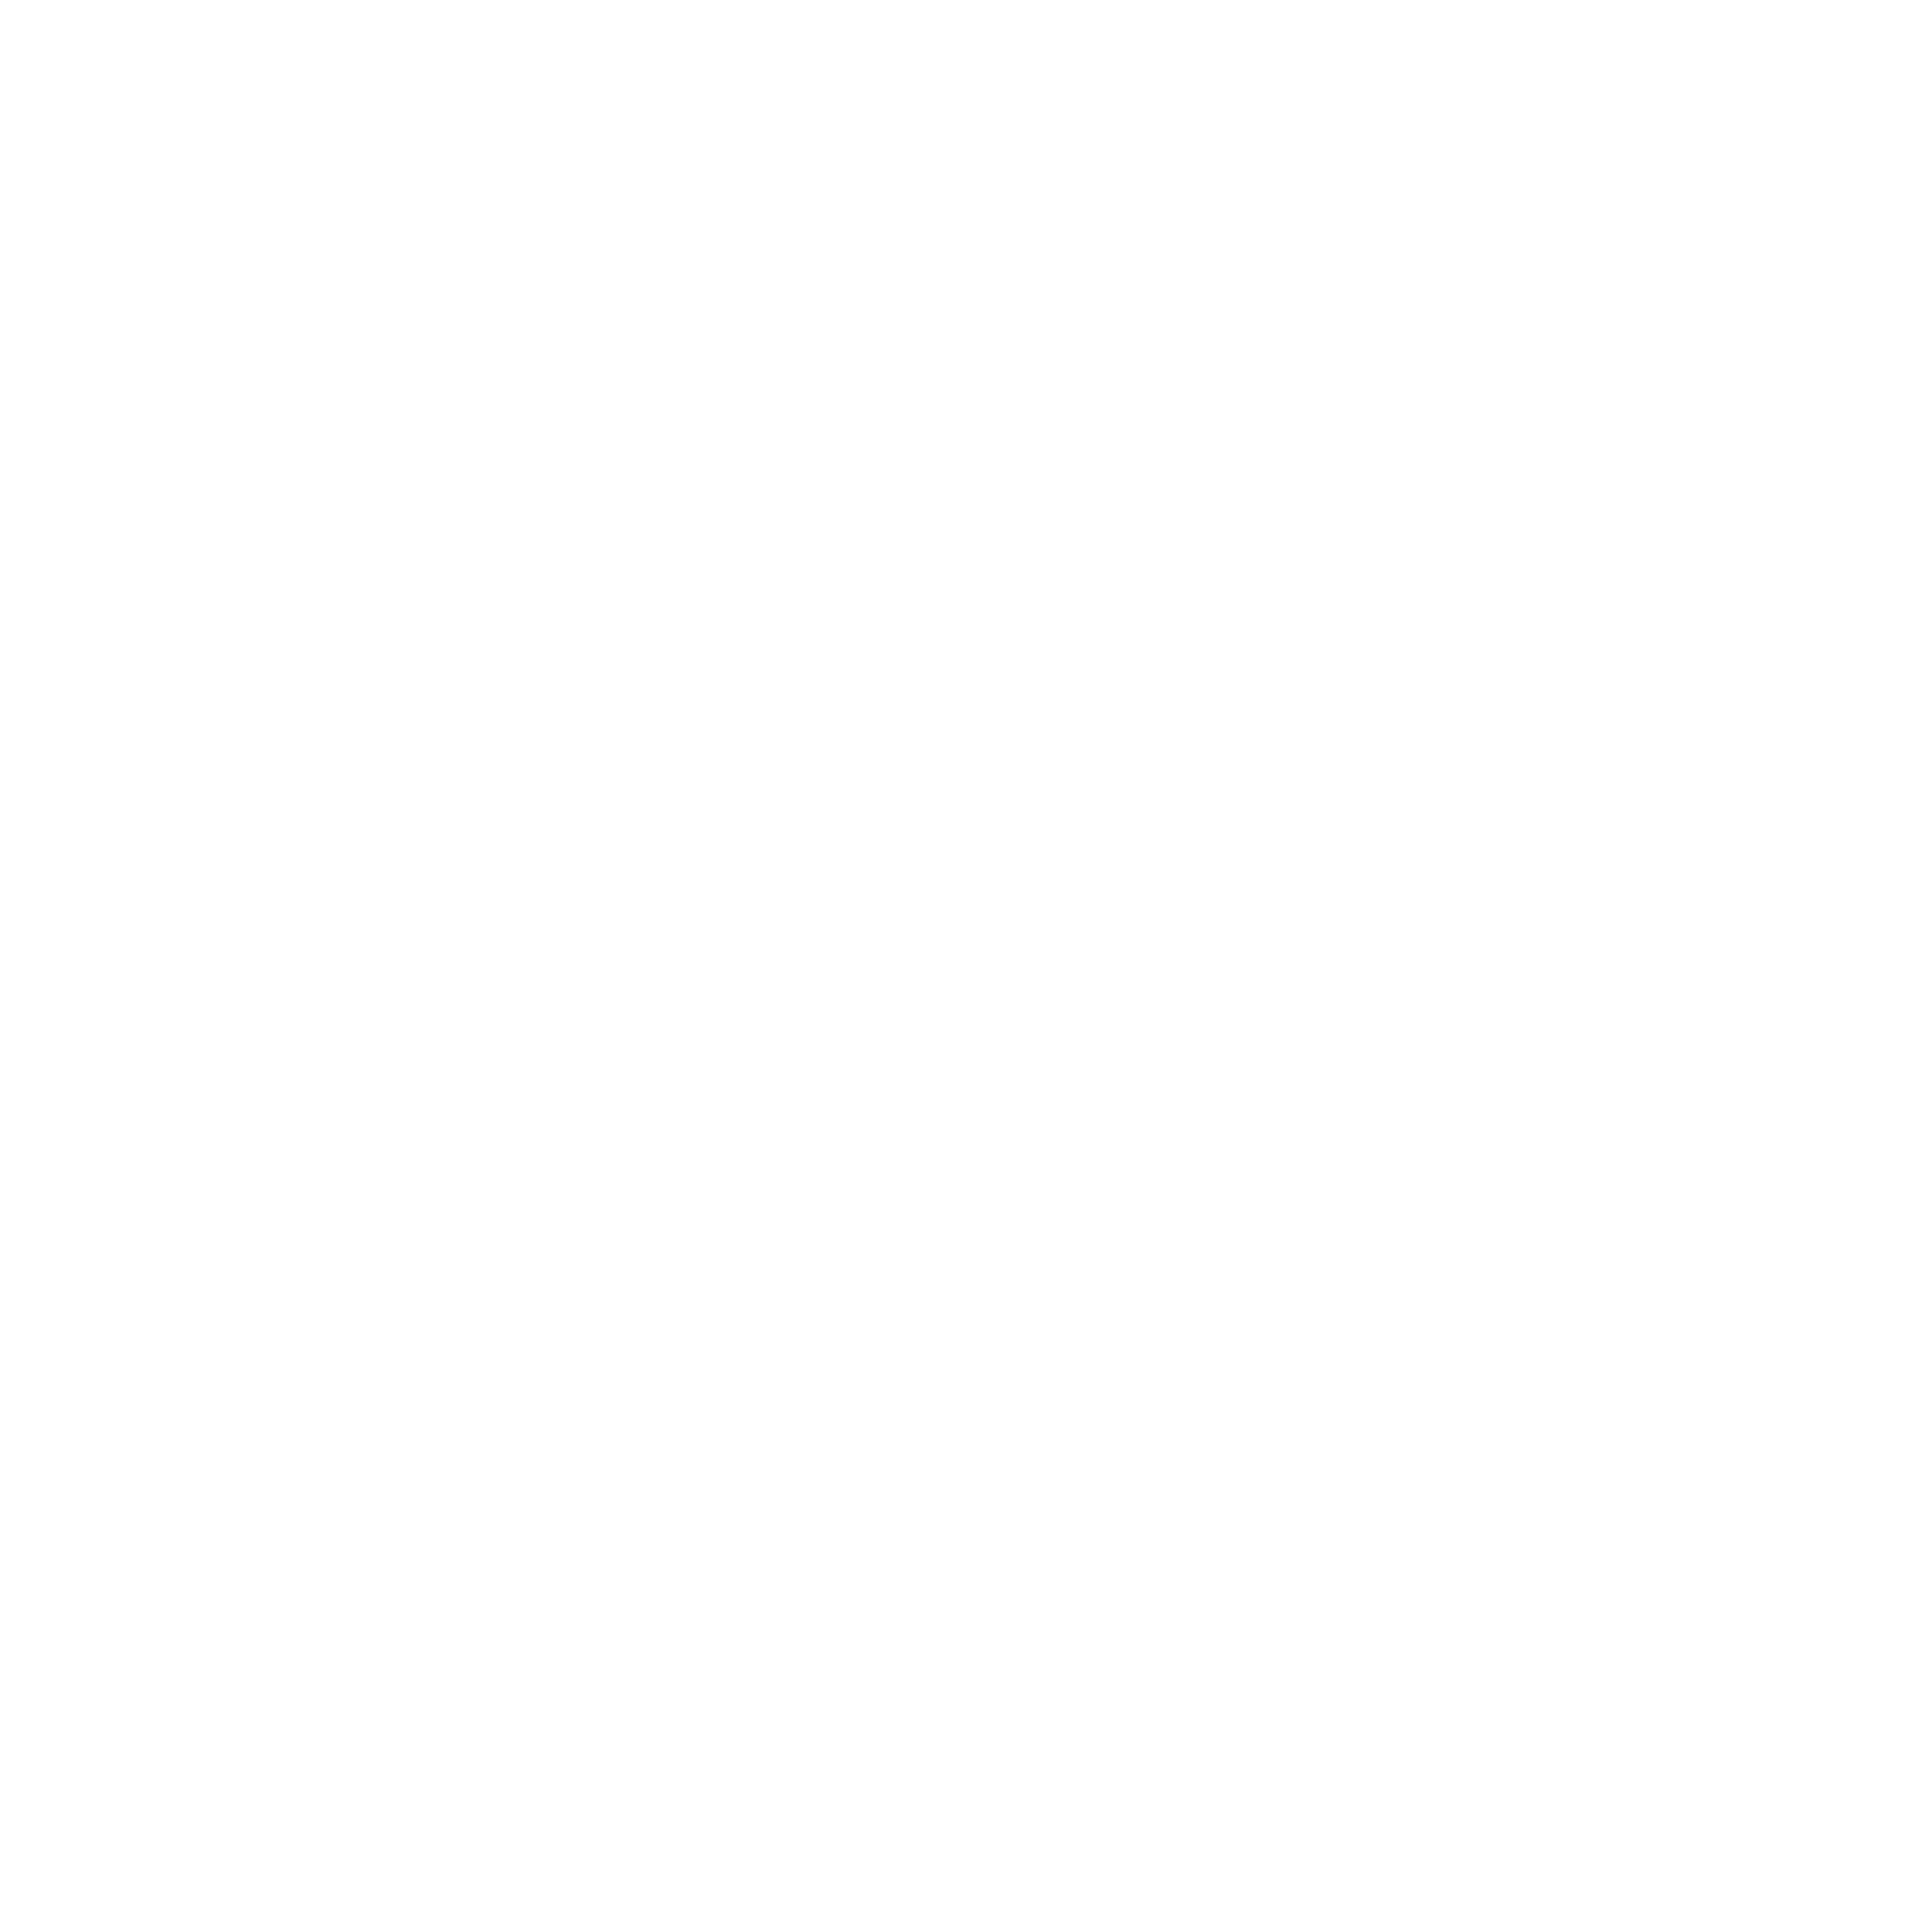

KeyboardInterrupt: 

In [111]:
#Assuming that the graph g has nodes and edges entered
save_graph(G,"my_graph_test.pdf")

On va essayer d'utiliser la librairie PyVis :
NON FONCTIONNEL

In [86]:
net = Network(notebook=True, cdn_resources="remote")

In [103]:
net.from_nx(G)

AssertionError: 

In [71]:
net.show("graph_2.html")

---

On va tester de faire une détection de communauté avec l'algo de Louvain

In [22]:
partition = community_louvain.best_partition(G)

In [30]:
len(set(partition.values()))

4382

In [55]:
partition

{817296: 0,
 764717: 1,
 727524: 2,
 852169: 3,
 890437: 1,
 649829: 1,
 101006853: 1,
 797977: 3,
 784974: 1,
 769886: 3,
 952384: 1,
 649266: 1,
 754104: 1,
 101023516: 1,
 821033: 1,
 101007085: 1090,
 101033844: 1,
 101003527: 5,
 101036560: 1,
 896904: 3,
 706072: 3,
 694368: 3,
 803370: 3,
 883811: 3,
 656824: 6,
 714666: 3,
 871914: 1,
 639739: 3,
 844271: 3,
 708507: 3,
 754051: 1,
 744277: 1,
 101032239: 1,
 645846: 3,
 897414: 3,
 101036763: 1,
 957051: 1,
 101037342: 1,
 694612: 3,
 691238: 3,
 817729: 7,
 700581: 1,
 784972: 1,
 959143: 13,
 730292: 1,
 730423: 1,
 649718: 1,
 826339: 1,
 101007492: 7,
 727988: 1,
 769177: 1090,
 776766: 13,
 757452: 3,
 953040: 1,
 957779: 1,
 857801: 1,
 695985: 1,
 769016: 1,
 945238: 1,
 693642: 7,
 845958: 1,
 754045: 1,
 957026: 1,
 101033781: 1,
 824389: 3,
 677379: 1,
 867564: 1,
 724101: 1,
 723623: 1,
 894356: 1,
 101036388: 1,
 847049: 1,
 840651: 2,
 690699: 1,
 642451: 1,
 101033778: 1,
 653569: 1,
 838448: 3,
 730222: 3,
 7238

In [26]:
partition_sorted = dict(sorted(partition.items()))

In [40]:
partition_sorted = pd.DataFrame.from_dict(partition_sorted, orient="index").astype({0:"int32"})

In [68]:
partition_df = pd.DataFrame.from_dict(partition, orient="index").astype({0:"int32"})
partition_df

,0
817296,0
764717,1
727524,2
852169,3
890437,1
...,...
807809,4
816437,8
790903,9
728611,17


In [69]:
test = pd.concat([project.set_index('id'), partition_df], axis=1, join='inner')

In [71]:
test.rename({0:"Community"}, axis=1, inplace=True)
test.head()

,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,ecSignatureDate,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi,Community
817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,2018-05-02,H2020,H2020-EIC-SMEInst-2018-2020,H2020-SMEInst-2018-2020-1,SME-1,NaN,"""Electronic discovery (known as e-discovery) i...",2022-08-10 13:07:21,217713,10.3030/817296,0
764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,2017-07-26,H2020,H2020-LCE-2016-2017,H2020-LCE-2017-RES-CSA,CSA,NaN,The overall objective of WinWind is to enhance...,2022-08-17 10:54:17,211548,10.3030/764717,1
784994,PentaHelix,CLOSED,Multi stakeholder and governance approach for ...,2018-03-01,2021-09-30,"1808343,75","1808343,75",H2020-EU.3.3.,EE-09-2016-2017,2018-02-05,H2020,H2020-EE-2016-2017,H2020-EE-2017-CSA-PPI,CSA,NaN,The PentaHelix project is focusing on developi...,2022-04-11 16:42:12,213566,10.3030/784994,1
841546,RES,TERMINATED,Rights for Ecosystem Services (RES): a framewo...,2020-01-13,2022-01-12,"224933,76","224933,76",H2020-EU.1.3.,MSCA-IF-2018,2019-04-11,H2020,H2020-MSCA-IF-2018,H2020-MSCA-IF-2018,MSCA-IF-EF-ST,NaN,Is currentIs current legal protection adequate...,2021-12-30 09:44:32,222283,10.3030/841546,1
716923,LEVIATHAN,CLOSED,Taming the Leviathan? Legal and Political Acco...,2017-08-01,2022-01-31,1184595,1184595,H2020-EU.1.1.,ERC-2016-STG,2016-11-29,H2020,ERC-2016-STG,ERC-2016-STG,ERC-STG,NaN,The Euro Crisis has had a transformative effec...,2022-09-08 18:14:15,206991,10.3030/716923,15


In [76]:
project = project.join(partition_sorted, on="id")

In [77]:
project.rename({0:"Community"}, axis=1, inplace=True)

Il manque la dernière valeur ! Il faut aussi modifier dtype de *Community* passer de float à int.

In [83]:
proportions = project['Community'].value_counts(normalize=True)
# proportions = proportions.cumsum()
# proportions.where(proportions >= 0.70)

In [84]:
proportions

1       0.246375
13      0.104435
11      0.071564
10      0.069048
12      0.059495
          ...   
1640    0.000028
1641    0.000028
1642    0.000028
1643    0.000028
574     0.000028
Name: Community, Length: 4377, dtype: float64

In [125]:
# proportions = proportions.cumsum()
proportions.where(proportions > 0.80).idxmax()

2

In [124]:
proportions.iloc[17]

0.858907323139538

In [71]:
absolue = project['Community']
absolue = absolue.sort_values(ascending=False)
absolue

35370    4381
35369    4380
35367    4379
35365    4378
35363    4377
         ... 
18655       1
18658       1
18661       1
18667       1
0           0
Name: Community, Length: 35381, dtype: int32

In [39]:
nx.set_node_attributes(G, partition, 'partition')

In [42]:
nx.write_gexf(G, "./graphe_3_labeled.gexf")

In [42]:
import random 
partitions = set(nx.get_node_attributes(G, 'partition').values())

# Sélection de quelques échantillons de chaque partition
sample_size = 2  # Nombre d'échantillons à sélectionner par partition
node_samples = {}  # Dictionnaire pour stocker les échantillons de chaque partition
for partition in partitions:
    # Récupération de la liste des noeuds appartenant à cette partition
    nodes = [node for node, data in G.nodes(data=True) if data['partition'] == partition]
    # Sélection aléatoire de quelques échantillons de cette liste
#     samples = random.sample(nodes, sample_size)
    samples = random.sample(nodes, min(sample_size, len(nodes)))
    # Ajout des échantillons au dictionnaire
    node_samples[partition] = samples

# Création d'un sous-graph avec les noeuds sélectionnés et leurs arcs
subgraph = G.subgraph(node_samples)

In [43]:
import itertools

# Création d'une liste de noeuds à inclure dans le sous-graph
nodes = list(itertools.chain(*node_samples.values()))
subgraph = G.subgraph(nodes)

In [ ]:
pos = nx.spring_layout(subgraph)  # Calcul des positions des noeuds
nx.draw(subgraph, pos, with_labels=True, node_size=800, font_size=12, font_weight='bold')
plt.show()